# Exploratory Data Analysis voor project "Gezondheidszorg"

## Imports van de te gebruiken libraries

In [83]:
import pandas as pd
import json
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sqlite3

## Ophalen van de data

De data kan op verschillende manieren worden opgehaald, maar in dit geval is er gekozen voor de manier via de rest server API. Hiervoor moet de rest server worden opgestart via een bash-script dat we hebben gekregen. Tot op heden heb ik nog geen manier gevonden om dit in een notebook te doen. We gaan er dus vanuit dat de rest server opgestart is. Als dit niet zo is werkt het onderstaande blok code niet. 

### Data ophalen via rest API

In [4]:
#url van API
url = "http://localhost:8080/medish_centrum_randstad/api/netlify?page=1"

#We slaan de response op 
response = requests.get(url).json()

#We slaan de response op als dataframe
df_fromAPI = pd.DataFrame(response['data'])

### Data ophalen met een SQLite query:

In [92]:
dbName = "rest_server/medisch_centrum_randstad/db.sqlite3"
tableName = "rest_api_netlify"

dbConnection = sqlite3.connect(dbName)

dfFromDB = pd.read_sql_query(f"SELECT * FROM {tableName}", dbConnection)
pd.set_option('display.max_columns', 10)

dfFromDB.drop(['id'], axis=1)

,genetic,length,mass,exercise,smoking,alcohol,lifespan,sugar
0,73.9,185.0,99.7,0.9,0.0,2.4,73.1,6.9
1,86.0,172.0,105.4,1.8,8.1,0.4,85.0,4.2
2,83.3,176.0,111.4,1.1,0.8,4.6,81.6,7.5
3,82.8,164.0,111.4,4.7,11.8,1.0,81.0,2.9
4,78.7,178.0,71.6,1.5,8.3,4.9,75.0,5.5
...,...,...,...,...,...,...,...,...
4091,80.3,176.0,115.9,3.7,0.1,5.6,80.7,5.8
4092,75.3,162.0,129.6,3.6,6.2,5.6,71.1,7.6
4093,93.1,189.0,115.3,2.7,9.4,4.9,90.0,6.6
4094,77.9,170.0,90.8,2.3,13.2,0.8,75.9,6.2


### Ophalen van data via .csv bestand

Omdat de data op de rest server nog niet is geupdate gebruiken we in dit geval het .csv bestand van de nieuwe database

In [35]:
#Csv inladen, zodra de nieuwe data via de server kan worden opgehaald verander ik de onderstaande code
df = pd.read_csv('data_new.csv')

#We werpen een eerste blik op het datafram en bekijken de dimensies
df.head(), df.shape

(  genetic length   mass exercise  smoking alcohol sugar  lifespan
 0    73.9    185   99.7      0.9      0.0     2.4   6.9      73.1
 1    86.0    172  105.4      1.8      8.1     0.4   4.2      85.0
 2    83.3    176  111.4      1.1      0.8     4.6   7.5      81.6
 3    82.8    164  111.4      4.7     11.8     1.0   2.9      81.0
 4    78.7    178   71.6      1.5      8.3     4.9   5.5      75.0,
 (4096, 8))

## Bekijken van data/eerste stappen in verkennen van de data

In deze eerste stappen bekijken we wat er in ons dataframe voorkomt qua waardes en type data:

In [36]:
#Kijken of de data lege cellen bevat:
df.isna().sum()

genetic     0
length      0
mass        0
exercise    0
smoking     0
alcohol     0
sugar       0
lifespan    0
dtype: int64

We hebben geen lege cellen zoals hierboven te zien is.

Zoals we te zien kregen bij .head() zouden alle kolommen van het dataframe allemaal floating point values moeten bevatten. Dit zou betekenen dat we met een "simpele" typecast alle waardes naar het type float kunnen omzetten. Dit geeft echter een error, waarin we lezen dat we o.a. cellen hebben waarin een '?' voorkomt. 

Dit brengt ons eigenlijk tot de vraag: zijn er cellen in het dataframe met waardes die __niet__ omgezet kunnen worden naar floats?

In [1]:
#Een manier om alle niet numerieke cellen te verwijderen:

#Eerst proberen we elke cel om te zetten naar een float, en maken we de cellen waarbij dit niet mogelijk is leeg/NaN:
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')

#We bekijken alle rijen met een NaN:
df[df.isna().any(axis=1)]

NameError: name 'df' is not defined

In [52]:
#Nu verwijderen we alle rijen die een NaN bevatten:

df = df.dropna()

In [53]:
#Nu checken we nogmaals de datatypes van alle kolommen, en zien we dat we enkel met floats te maken hebben:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4086 entries, 0 to 4095
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   genetic   4086 non-null   float64
 1   length    4086 non-null   float64
 2   mass      4086 non-null   float64
 3   exercise  4086 non-null   float64
 4   smoking   4086 non-null   float64
 5   alcohol   4086 non-null   float64
 6   sugar     4086 non-null   float64
 7   lifespan  4086 non-null   float64
dtypes: float64(8)
memory usage: 287.3 KB


Een volgende stap kan zijn: het bekijken van het aantal 0 waardes per kolom (dus cellen die daadwerkelijke als waarde 0 hebben; het gaat hier niet om lege cellen). We weten immers dat er variabelen, zoals 'genetic', 'length', 'mass' en 'lifespan' zijn die nooit 0 kunnen zijn:

In [54]:
print(df.isin([0]).sum(axis=0))

genetic      0
length       0
mass         0
exercise     0
smoking     53
alcohol     12
sugar        0
lifespan     0
dtype: int64


We zien dus dat we geen 0 waardes hebben binnen variabelen waarbij dit niet zou kunnen. Mooi. 

We kunnen nu wat descriptive statistics van ons dataframe ophalen. Dit is handig aangezien we zo vrij snel kunnen zien of er bijvoorbeeld vreemde uitersten in de data zitten:

In [55]:
df.describe()

,genetic,length,mass,exercise,smoking,alcohol,sugar,lifespan
count,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000,4086.000000
mean,82.280127,183.879344,92.273837,2.403353,9.812677,2.266006,6.484973,80.137959
std,7.440070,12.627470,25.800771,1.170593,6.919057,1.801020,2.709868,8.041656
min,63.900000,154.000000,50.000000,0.100000,0.000000,0.000000,0.700000,-1.000000
25%,77.600000,175.000000,71.425000,1.500000,3.400000,0.600000,4.400000,75.000000
50%,81.800000,184.000000,89.500000,2.200000,9.500000,1.700000,6.300000,79.700000
75%,86.700000,193.000000,110.875000,3.200000,15.900000,4.000000,8.400000,85.200000
max,102.200000,214.000000,163.600000,5.500000,22.200000,6.000000,13.800000,105.100000


## Spotten van afwijkende waardes/outliers

Zoals we hierboven zien hebben we bij de kolom 'lifespan' een minimale waarde van -1. Dit is natuurlijk niet mogelijk.
We kunnen de boxplot van 'lifespan' laten zien om te kijken of er verder nog gekke outliers zijn:

<AxesSubplot: xlabel='lifespan'>

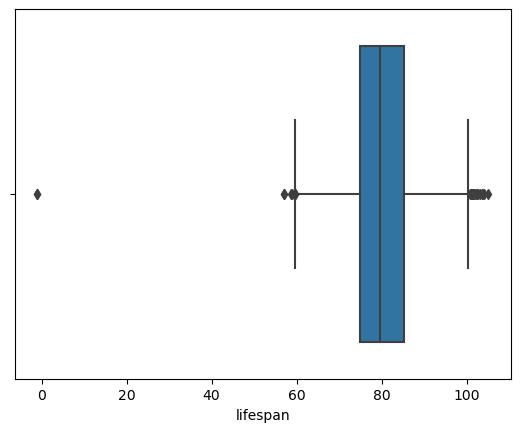

In [56]:
sns.boxplot(x=df['lifespan'])

In [57]:
#We zien de outliers ook terug op de boxplot. Dit zegt ons echter niets over het aantal -1 waardes. Dit checken we dus:
df.loc[df['lifespan'] < 0]

,genetic,length,mass,exercise,smoking,alcohol,sugar,lifespan
889,88.1,156.0,112.9,0.7,19.5,0.9,3.0,-1.0
2300,82.6,188.0,63.1,3.6,15.0,0.2,1.0,-1.0


In [59]:
#We hebben dus twee gevallen met een niet-kloppende lifespan. Deze verwijderen we:
df.drop(df.loc[df['lifespan'] < 0].index, inplace=True)

In [60]:
#Nu zien we dat er geen -1 gevallen meer tussen zitten:
df.loc[df['lifespan'] < 0]

,genetic,length,mass,exercise,smoking,alcohol,sugar,lifespan


Als volgende stap bekijken we ook alle boxplots van de andere variabelen.

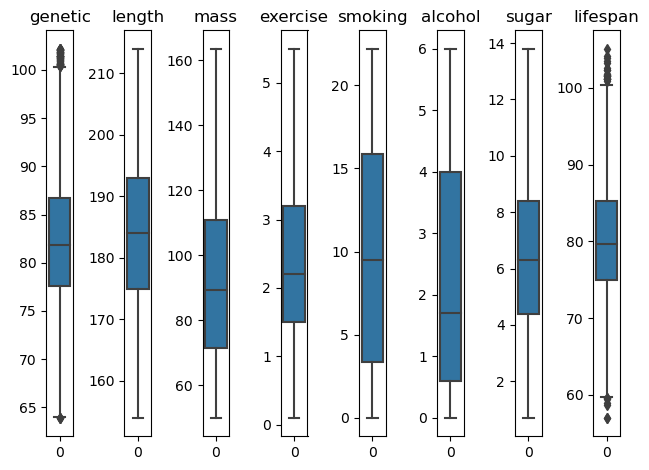

In [78]:
cols = [c for c in df.columns]

fig, axes = plt.subplots(ncols=len(cols))

for column, axis in zip(cols, axes):
        sns.boxplot(data=df[column], ax=axis) 
        axis.set_title(column)
        
plt.tight_layout()
plt.show()

Hierboven zien we dat we alleen bij 'genetic' en 'lifespan' nog uitschieters hebben naar boven en beneden. De vraag is nu: zijn dit, zoals onze -1 bij 'lifespan', daadwerkelijk verkeerde datapunten, of zijn deze uitschieters "gewoon" onderdeel van de data. Er zijn immers mensen die een stuk jonger of ouder worden dan de meeste mensen. In dit geval is er besloten om deze uitschieters niet te verwijderen aangezien ze niet onwaarschijnlijk zijn, en het vrijwel zeker is dat dit echte datapunten zijn.

## Feature extraction/engineering

Nu we een redelijk schoon dataframe hebben zonder echte outliers, kunnen we kijken of we bepaalde features kunnen maken of bewerken. We beginnen met het aanmaken van een BMI kolom:

In [115]:
#We berekenen de bmi volgens de standaard formule:
df['BMI'] = df['mass'] / ((df['length'])/100)**2

#We kijken naar onze nieuwe variabel
df['BMI'].describe()

count    4084.000000
mean       27.682015
std         8.711661
min        11.320500
25%        20.938542
50%        26.476726
75%        33.207260
max        65.869494
Name: BMI, dtype: float64

In [132]:
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
df['BMI cat'] = pd.cut(df['BMI'], bins=[0,18.5,25,30,70], labels=labels)

In [133]:
df['BMI cat'].value_counts()

Obese          1487
Normal         1151
Overweight      851
Underweight     595
Name: BMI cat, dtype: int64

In [137]:
df[['BMI cat', 'lifespan']].groupby(['BMI cat'], as_index=False).mean().sort_values(by='BMI cat')

,BMI cat,lifespan
0,Underweight,80.133109
1,Normal,80.480365
2,Overweight,81.003408
3,Obese,79.488702
